# Generating Animals using a Diffusion Model based on UNET

----
- **Chosen Paper:** [Diffusion Models Beat GANs on Image Synthesis [Dhariwal, Nichol, 2021]](https://openreview.net/pdf?id=AAWuCvzaVt)
- **Published at:** NeurIPS21
- **Reason for selection:** The reason for choosing this paper is because it had a big impact on how images are generated. The study showed that a diffusion model can produce better results than Generative Adversarial Networks (GANs). This discovery led to a significant change in how researchers approach image generation. By demonstrating better performance in creating images, the paper questioned the dominance of GANs, which have been the main method for making realistic images. This change not only drew a lot of interest from academics but also encouraged more study into diffusion models and how they could be used in different areas besides image generation. Overall, the paper provides important insights and has sparked new ideas for research in visual media and artificial intelligence.


----------
**Other Sources**
- Used Dataset ([Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/))
- Used Tutorials ([Diffusion Models - Live Coding Tutorial
](https://youtu.be/S_il77Ttrmg), )
- Used Repositories ([Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch), [The Annotated Diffusion Model](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023))

-------
**Modification Overview:**
- Dataset change to Dogs and Cats
- Changed order and structure of code blocks
- Code adjustments and comments
- Tested different hyper parameters such as batch sizes, epochs, etc.
- Added weight saving and resuming mechanism
--------

# Setup

## Imports

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

from google.colab import files

## Dataset

100%|██████████| 791918971/791918971 [01:25<00:00, 9237915.53it/s]


Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 7294392.68it/s] 


Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet


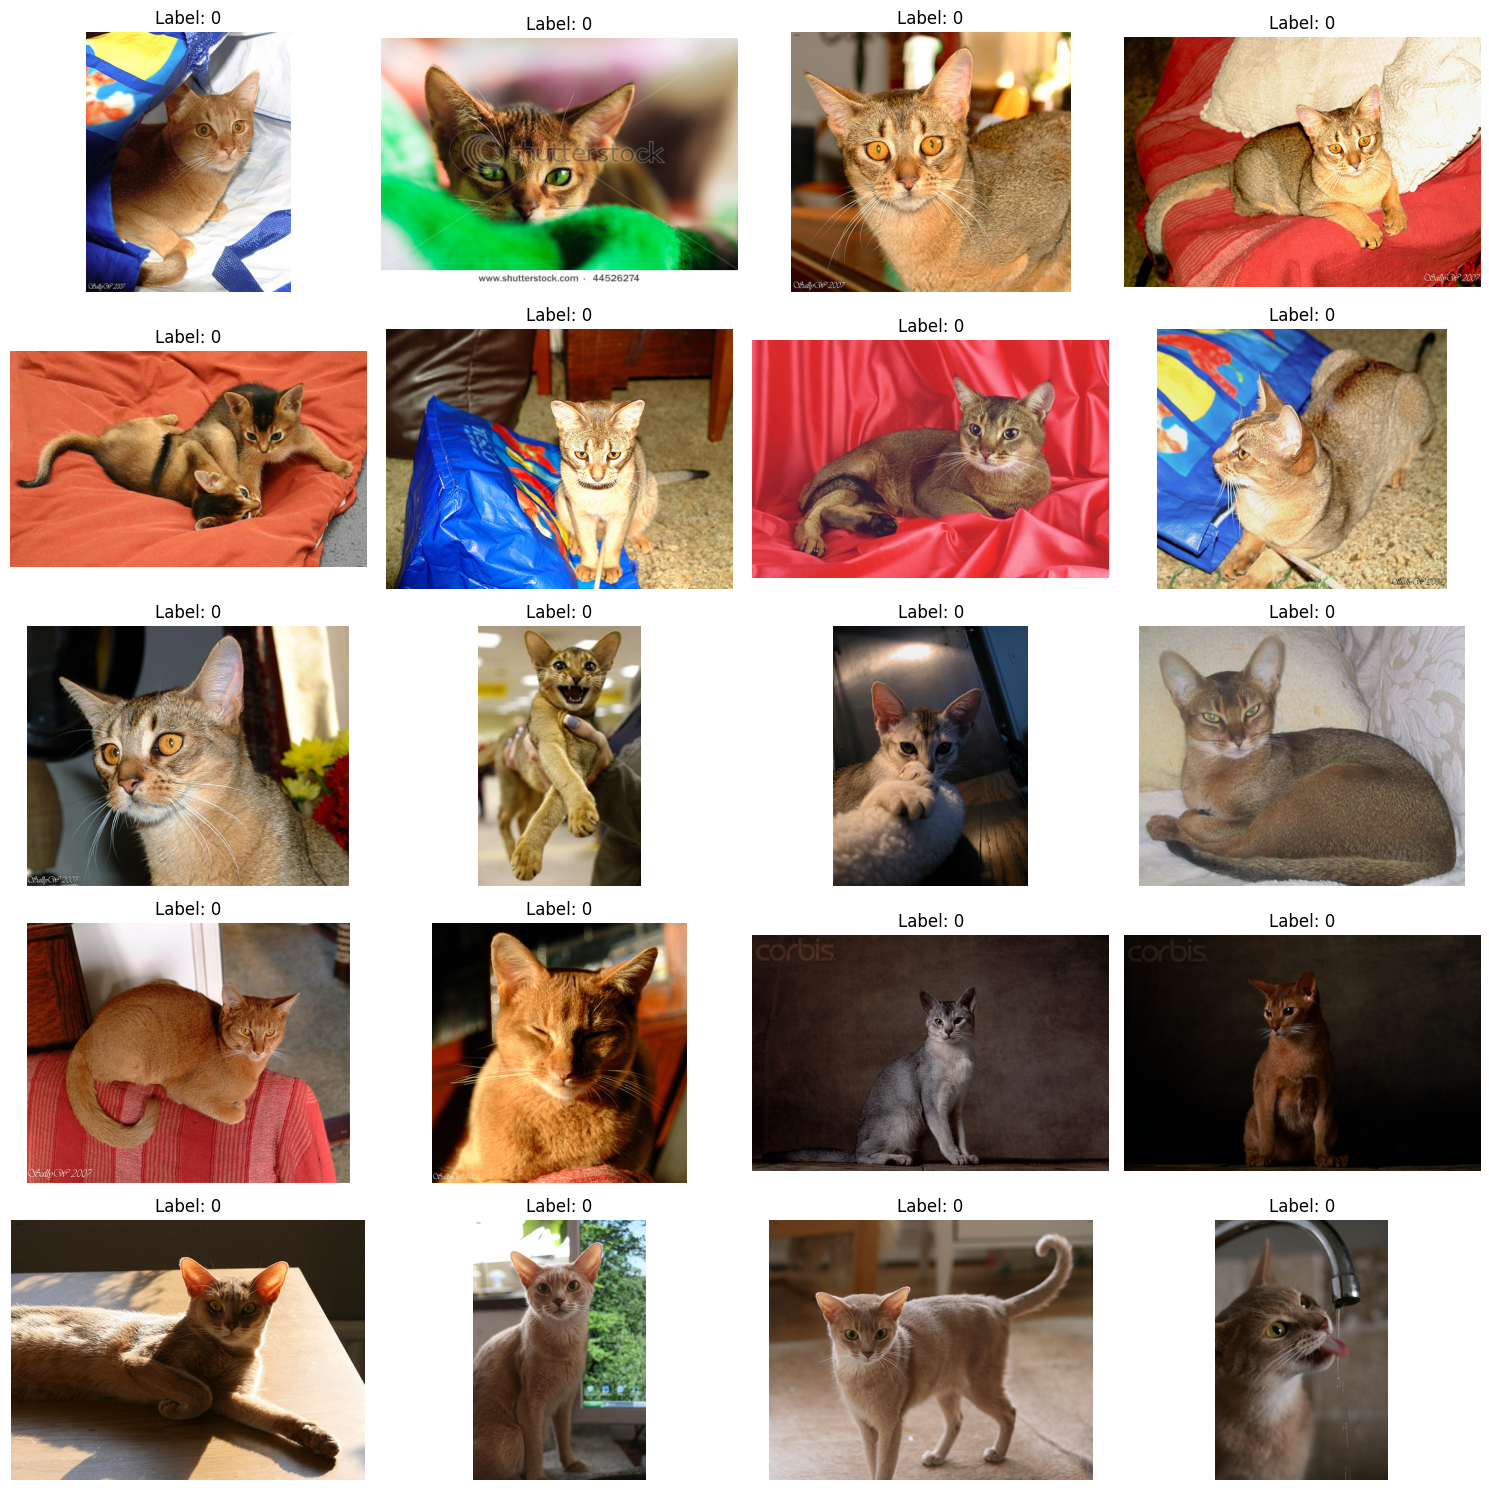

In [2]:
def show_images(dataset, num_samples=20, cols=4):
    """Plots some samples from the dataset."""
    plt.figure(figsize=(15,15))
    rows = (num_samples + cols - 1) // cols  # Calculate the number of rows needed
    for i in range(num_samples):
        if i >= len(dataset):
            break
        img, label = dataset[i]
        img = img.permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Download the dataset
data = torchvision.datasets.OxfordIIITPet(root="./", download=True, transform=torchvision.transforms.ToTensor())

# Show images from the dataset
show_images(data)


# Image (Pre-)Processing

## Step 1: The forward process = Noise scheduler




In [3]:
IMG_SIZE = 64
BATCH_SIZE = 128
T = 300  # Number of timesteps for diffusion
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
def load_transformed_dataset():
    """
    Loads and transforms the OxfordIIITPet dataset.
    Returns a concatenated dataset of train and test splits.
    """
    data_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
    ])

    train_dataset = torchvision.datasets.OxfordIIITPet(root="./", download=True, transform=data_transforms)
    test_dataset = torchvision.datasets.OxfordIIITPet(root="./", download=True, transform=data_transforms, split='test')

    # Return concatenated train and test datasets
    return torch.utils.data.ConcatDataset([train_dataset, test_dataset])

def show_tensor_image(image):
    """
    Displays a tensor image.
    """
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),  # Scale back to [0, 1]
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),  # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),  # Scale to [0, 255]
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),  # Convert to uint8
        transforms.ToPILImage()  # Convert to PIL Image
    ])

    # Take the first image of the batch if batch dimension exists
    if len(image.shape) == 4:
        image = image[0]

    plt.imshow(reverse_transforms(image))
    plt.axis('off')

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    """
    Returns a linear schedule of betas from start to end over the given timesteps.
    """
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t from a list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and returns the noisy version of it.
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    # mean + variance
    noisy_image = sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
    return noisy_image, noise




<ipython-input-5-2744d9272b36>:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images + 1, int(idx / stepsize) + 1)


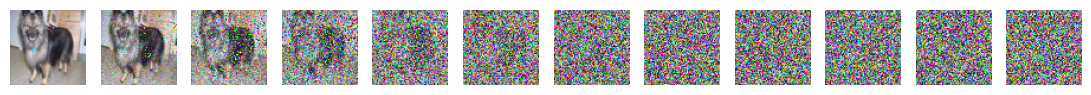

In [5]:
# Define beta schedule
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

# Load dataset and create dataloader
data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15, 15))
plt.axis('off')
num_images = 12
stepsize = int(T / num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images + 1, int(idx / stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

plt.show()

## Step 2: The Diffusion Model / UNet

**Key Takeaways**:
- We use a simple form of a UNet for to predict the noise in the image
- The input is a noisy image, the ouput the noise in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one single value (mean), because the variance is fixed


In [6]:
import torch
from torch import nn
import math

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, kernel_size=3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        # First Conv
        h = self.conv1(x)
        h = self.relu(self.bnorm1(h))
        # Time embedding
        time_emb = self.time_mlp(t)
        time_emb = time_emb.unsqueeze(-1).unsqueeze(-1)
        h = h + time_emb
        # Second Conv
        h = self.conv2(h)
        h = self.relu(self.bnorm2(h))
        # Down or Upsample
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 3  # RGB
        down_channels = (64, 128, 256, 512, 1024)  # Channels for down-sampling
        up_channels = (1024, 512, 256, 128, 64)  # Channels for up-sampling
        out_dim = 3
        time_emb_dim = 32

        # Time embedding MLP
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], kernel_size=3, padding=1)

        # Down-sampling layers
        self.downs = nn.ModuleList([
            Block(down_channels[i], down_channels[i + 1], time_emb_dim)
            for i in range(len(down_channels) - 1)
        ])

        # Up-sampling layers
        self.ups = nn.ModuleList([
            Block(up_channels[i], up_channels[i + 1], time_emb_dim, up=True)
            for i in range(len(up_channels) - 1)
        ])

        # Output layer
        self.output = nn.Conv2d(up_channels[-1], out_dim, kernel_size=1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []

        # Down-sampling with residual connections
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)

        # Up-sampling with concatenated residuals
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)

        return self.output(x)

# Instantiate the model
model = SimpleUnet()

# Print the number of parameters
num_params = sum(p.numel() for p in model.parameters())
print("Number of parameters:", num_params)

# Print the model architecture
print(model)


Number of parameters: 62438883
SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), 

## Step 3: The loss



**Key Takeaways:**
- After some maths we end up with a very simple loss function
- There are other possible choices like L2 loss ect.


In [7]:
def get_loss(model, x_0, t, device="cpu"):
    """
    Computes the loss for the given model, original image x_0, and timestep t.

    Args:
    - model (nn.Module): The model to evaluate.
    - x_0 (torch.Tensor): The original, clean images.
    - t (torch.Tensor): The timesteps at which to evaluate the model.
    - device (str): The device on which to perform computations ("cpu" or "cuda").

    Returns:
    - torch.Tensor: The computed L1 loss.
    """
    # Forward diffusion process to add noise
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)

    # Predict the noise using the model
    noise_pred = model(x_noisy, t)

    # Compute the L1 loss between the actual noise and the predicted noise
    loss = F.l1_loss(noise, noise_pred)

    return loss


## Sampling


In [8]:
@torch.no_grad()
def sample_timestep(model, x, t):
    """
    Predicts the denoised image at timestep t.

    Args:
    - model (nn.Module): The model to use for noise prediction.
    - x (torch.Tensor): The noisy input image.
    - t (torch.Tensor): The current timestep.

    Returns:
    - torch.Tensor: The denoised image.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Model's prediction of the noise in the image
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t.item() == 0:
        # If t == 0, return the model mean without adding noise
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image(model, device):
    """
    Generates and plots a series of images showing the denoising process.

    Args:
    - model (nn.Module): The model to use for noise prediction.
    - device (str or torch.device): The device to perform computations on.
    """
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T / num_images)

    for i in range(T - 1, -1, -1):
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(model, img, t)
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i / stepsize) + 1)
            show_tensor_image(img.detach().cpu())
    plt.show()


# Training

Pretrained weights file does not exist, new training started
Epoch 0 | Step 000 | Loss: 0.8039528131484985


<ipython-input-8-04412d4ff7b0>:54: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i / stepsize) + 1)


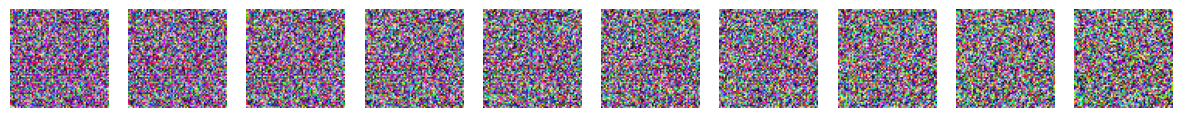

Epoch 5 | Step 000 | Loss: 0.2004871368408203


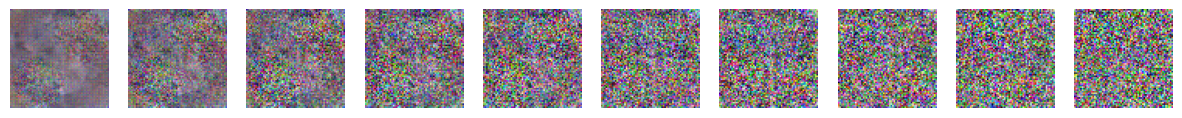

Epoch 10 | Step 000 | Loss: 0.1898096799850464


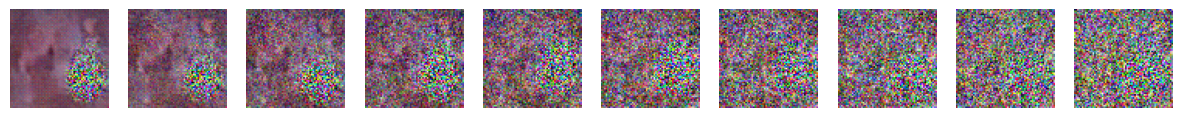

Epoch 15 | Step 000 | Loss: 0.1763475388288498


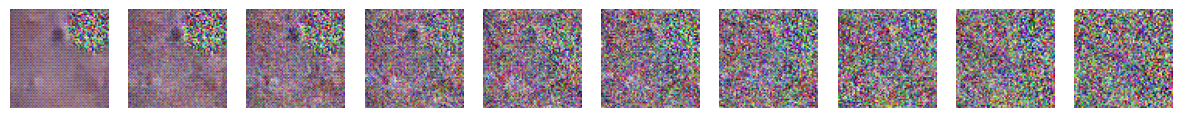

Epoch 20 | Step 000 | Loss: 0.17827658355236053


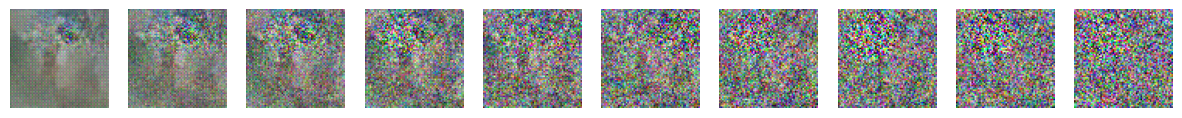

Epoch 25 | Step 000 | Loss: 0.1689385622739792


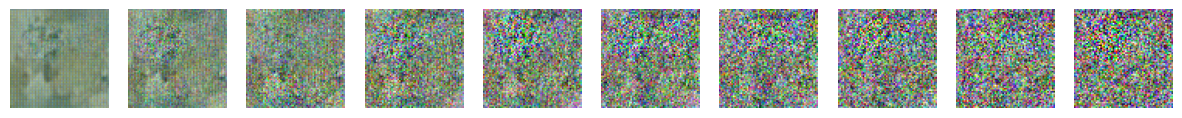

Epoch 30 | Step 000 | Loss: 0.19627635180950165


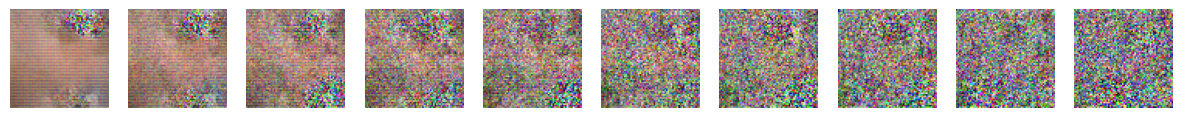

Epoch 35 | Step 000 | Loss: 0.17862683534622192


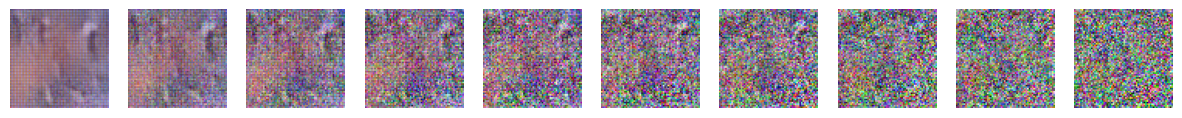

Epoch 40 | Step 000 | Loss: 0.16156354546546936


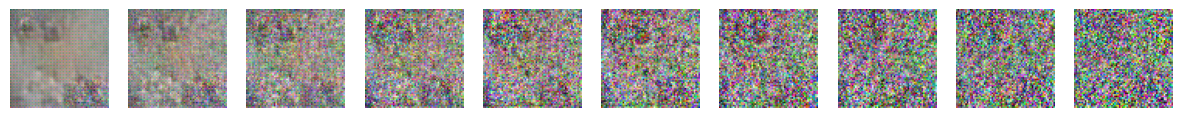

Epoch 45 | Step 000 | Loss: 0.16924640536308289


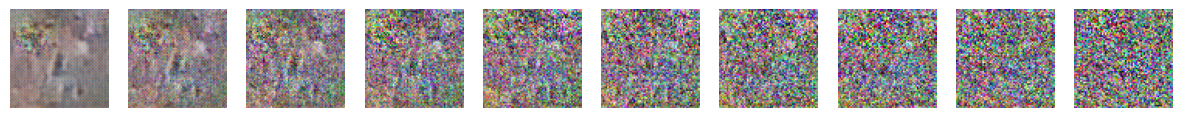

Epoch 50 | Step 000 | Loss: 0.16902673244476318


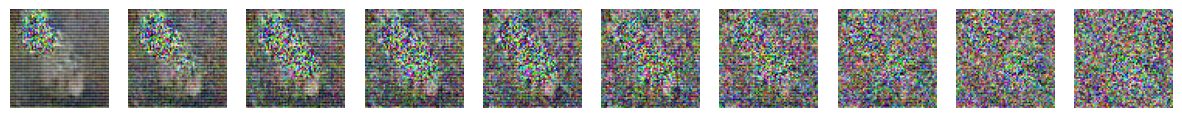

Epoch 55 | Step 000 | Loss: 0.16720354557037354


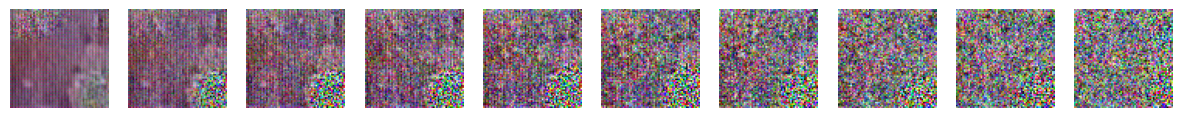

Epoch 60 | Step 000 | Loss: 0.18343713879585266


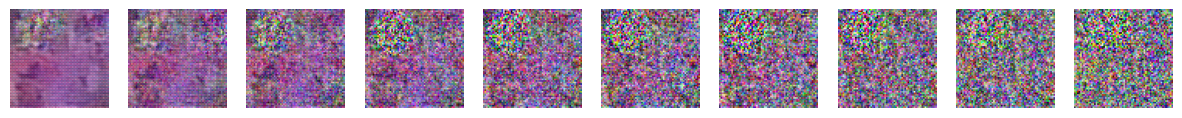

In [ ]:
import zipfile

# Set device to GPU if available, else CPU
device = "cuda" if torch.cuda.is_available() else "cpu"


# Path to the saved model weights
weight_path = "/content/epoch_45.pth"

# Load model weights if they exist
if os.path.exists(weight_path):
    model.load_state_dict(torch.load(weight_path, map_location=device))
    print(f"Loaded weights from {weight_path}")
else:
    print("Pretrained weights file does not exist, new training started")

# Move model to the appropriate device
model.to(device)

# Define the optimizer
optimizer = Adam(model.parameters(), lr=0.001)

# Number of training epochs
epochs = 200

# Training loop
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Move batch to device
        batch = [b.to(device) for b in batch]

        # Random timesteps for each sample in the batch
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()

        # Compute the loss
        loss = get_loss(model, batch[0], t, device)

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Print and save model at regular intervals
        if epoch % 5 == 0 and step == 0:
            print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()}")
            sample_plot_image(model, device)
            save_path = f"epoch_{epoch}.pth"
            torch.save(model.state_dict(), save_path)

In [ ]:
# Create a ZIP archive
zip_file_path = 'model.zip'
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    zipf.write(weight_path, os.path.basename(weight_path))
files.download(zip_file_path) # Download the saved model checkpoint